In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import pytz
from pytz import timezone
from geopy.distance import vincenty

from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
tz = timezone('US/Central') # This data uses GMT-6 rather than standard CST/CDT
def toUTC(d):
    return tz.normalize(tz.localize(d)).astimezone(pytz.utc)

In [7]:
def string2datetime(stringDTSeries):
    try:
        return [(dt.datetime.strptime(DT,'%Y/%m/%d %I:%M:%S %p')) for DT in stringDTSeries]
    except(ValueError):
        try:
            return [(dt.datetime.strptime(DT,'%Y/%m/%d %H:%M:%S')) for DT in stringDTSeries]
        except(ValueError):
            try:
                return [(dt.datetime.strptime(DT,'%m/%d/%Y %I:%M:%S %p')) for DT in stringDTSeries]
            except(ValueError):
                try:
                    return [(dt.datetime.strptime(DT,'%m/%d/%Y %H:%M:%S')) for DT in stringDTSeries]
                except(ValueError):
                    return [(dt.datetime.strptime(DT,'%m/%d/%y %H:%M:%S')) for DT in stringDTSeries]

In [12]:
path = '/Volumes/RT&O/C Brace/GPS Analysis/' #mac
# path = 'X:/C Brace/GPS Analysis/' #win


## Add LandUse coordinates and weartime to UIC preprocessed GPS files

In [ ]:
x = Gpsdata['UTC DATE']+' '+Gpsdata['UTC TIME'] #full date/time
GpsDates = string2datetime(x) #convert to datetime object
GpsDates=pd.Series(GpsDates)

In [36]:
GpsDates[:10]

0   2015-02-10 17:42:37
1   2015-02-10 17:42:47
2   2015-02-10 17:42:57
3   2015-02-10 17:43:07
4   2015-02-10 17:43:17
5   2015-02-10 17:43:27
6   2015-02-10 17:43:37
7   2015-02-10 17:43:47
8   2015-02-10 17:43:57
9   2015-02-10 17:44:07
dtype: datetime64[ns]

In [83]:
#load single file - TEST
fraw = 'CBR08_CBrace.csv'
fuic = 'CBR08_Final_Summary_File.xlsx'
Gpsdata = pd.read_csv(path+'GPSWT/'+fraw)
Baseline = pd.read_excel(path+'UIC_GPSData/'+fuic,sheetname='CBR')


loc_lat = [];    loc_lon = [];  wear_frac = []; num_points = []
spd_min = []; spd_max = []; spd_mean = []; spd_median = []
duration = []; gap_min = [];  gap_max = []; gap_mean = []; gap_median = [] 


#Drop unnecessary cols from UIC table
Baseline = Baseline.drop(['MeanSpeed','Numberpoints','Duration','TotalGap'],axis=1)
print(Baseline.head())

#convert date formats from raw gps
x = Gpsdata['UTC DATE']+' '+Gpsdata['UTC TIME'] #full date/time
GpsDates = string2datetime(x) #convert to datetime object
GpsDates=pd.Series(GpsDates)

for i in range(len(Baseline)):
    if i%(len(Baseline)/10) == 0:
        print(str(i)+'%')
    start = Baseline.BeginTime[i]
    end = Baseline.EndTime[i]
    d = Baseline.Date[i]

    if type(d) != str:
        d = d.strftime('%Y/%m/%d') 
    if type(start) != str:
        start = str(start)
    if type(end) != str:
        end = str(end)
    try:
        startdate = toUTC(dt.datetime.strptime(d+' '+start,'%Y/%m/%d %H:%M:%S'))
        enddate = toUTC(dt.datetime.strptime(d+' '+end,'%Y/%m/%d %H:%M:%S'))
    except(ValueError):
        try:
            startdate = toUTC(dt.datetime.strptime(d+' '+start,'%m/%d/%y %H:%M:%S'))
            enddate = toUTC(dt.datetime.strptime(d+' '+end,'%m/%d/%y %H:%M:%S'))
        except(ValueError):
            try:
                startdate = toUTC(dt.datetime.strptime(d+' '+start,'%m/%d/%Y %H:%M:%S'))
                enddate = toUTC(dt.datetime.strptime(d+' '+end,'%m/%d/%Y %H:%M:%S'))
            except(ValueError):
                startdate = toUTC(dt.datetime.strptime(d+' '+start,'%Y-%m-%d %H:%M:%S'))
                enddate = toUTC(dt.datetime.strptime(d+' '+end,'%Y-%m-%d %H:%M:%S'))


    #find matching dates between 2 files (processed and raw) and compute features
    ind = (GpsDates >= startdate) & (GpsDates <= enddate)
    #compute and store features
    meanLat = np.mean(Gpsdata['LATITUDE'][ind])
    meanLon = np.mean(Gpsdata['LONGITUDE'][ind])
    if np.isnan(meanLat) or np.isnan(meanLon):
        print('null found %s'%any(ind))
        print(startdate,enddate)
    loc_lat.append(meanLat)
    loc_lon.append(meanLon)
    spd_min.append(np.min(Gpsdata['SPEED'][ind]))
    spd_max.append(np.max(Gpsdata['SPEED'][ind]))                
    spd_mean.append(np.mean(Gpsdata['SPEED'][ind]))
    spd_median.append(np.median(Gpsdata['SPEED'][ind]))
    num_points.append(sum(ind))
    duration.append(enddate-startdate)
    #gaps between points in secs in rawgps data for daterange
    td = GpsDates[ind].diff()
    gap_min.append(td.min().total_seconds())
    gap_max.append(td.max().total_seconds())
    gap_mean.append(td.mean().total_seconds())
    gap_median.append(td.median().total_seconds())

    wear_ind = (Gpsdata['Wear/Non-Wear']=='Wear') & ind
    wear_frac.append(sum(wear_ind)/sum(ind))

Baseline['Mean Lat'] = loc_lat; Baseline['Mean Lon'] = loc_lon; Baseline['Wear Frac'] = wear_frac
Baseline['Duration'] = duration; Baseline['Numpoints'] = num_points
Baseline['Speed_Mean'] = spd_mean; Baseline['Speed_Min'] = spd_min; Baseline['Speed_Max'] = spd_max
Baseline['Speed_Median'] = spd_median
Baseline['Gap_Min'] = gap_min; Baseline['Gap_Max']=gap_max; Baseline['Gap_Mean']=gap_mean; 
Baseline['Gap_Median']=gap_median


# Compute Min, Max, Median, Mean of speed
# Compute duration
# Number of Raw GPS points
# Min, Max, mean, std of gaps b/w points

# Number of unclustered data points for each Subject/Brace

        Date  Sequence BeginTime   EndTime Mode     LandUse
0 2015-02-10         1  11:42:37  12:09:58  Car        Trip
1 2015-02-10         2  12:10:08  12:17:18  NaN  COM_URBMIX
2 2015-02-10         3  12:17:28  12:36:28  Car        Trip
3 2015-02-10         4  12:36:38  12:45:38  NaN  COM_URBMIX
4 2015-02-10         5  12:45:48  13:55:10  Car        Trip
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


In [84]:
Baseline.head()

,Date,Sequence,BeginTime,EndTime,Mode,LandUse,Mean Lat,Mean Lon,Wear Frac,Duration,Numpoints,Speed_Mean,Speed_Min,Speed_Max,Speed_Median,Gap_Min,Gap_Max,Gap_Mean,Gap_Median
0,2015-02-10,1,11:42:37,12:09:58,Car,Trip,41.870200,87.711023,1,00:27:21,165,46.940548,0.163532,109.548119,47.974251,10.0,11.0,10.006098,10.0
1,2015-02-10,2,12:10:08,12:17:18,NaN,COM_URBMIX,41.830436,87.803025,1,00:07:10,44,2.284377,0.047465,32.243301,0.642872,10.0,10.0,10.000000,10.0
2,2015-02-10,3,12:17:28,12:36:28,Car,Trip,41.839046,87.767186,1,00:19:00,115,20.067299,0.019340,66.380928,21.266867,10.0,10.0,10.000000,10.0
3,2015-02-10,4,12:36:38,12:45:38,NaN,COM_URBMIX,41.851519,87.747862,1,00:09:00,55,1.562509,0.004843,15.570488,0.511654,10.0,10.0,10.000000,10.0
4,2015-02-10,5,12:45:48,13:55:10,Car,Trip,41.872845,87.685020,1,01:09:22,379,26.829532,0.089908,98.430122,21.596622,10.0,123.0,11.010582,10.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x118bb82d0>], dtype=object)

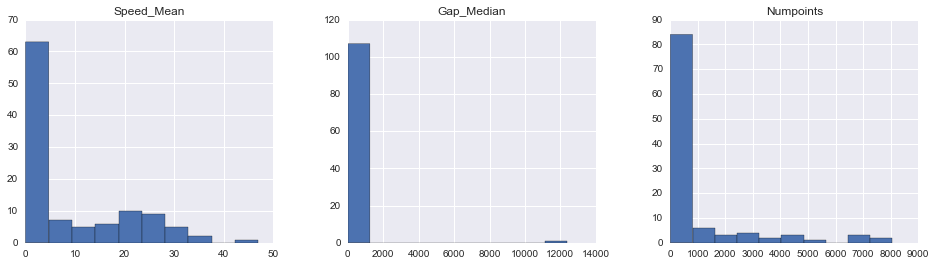

In [99]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(131)
Baseline[['Speed_Mean']].hist(ax=ax)
ax = fig.add_subplot(132)
Baseline[['Gap_Median']].hist(ax=ax)
ax = fig.add_subplot(133)
Baseline[['Numpoints']].hist(ax=ax)


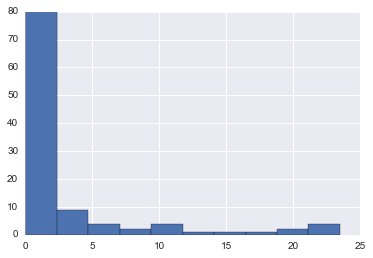

In [121]:
Baseline['Duration'].apply(lambda x: x.total_seconds()/60/60).hist()

In [38]:
#Baseline: UIC Gps preprocessed Data
#GPSdata: raw Gps data with wear time fraction
#GpsDates: datetime object from Gpsdata to match with UIC data
def add_latlonwear(Baseline,Gpsdata,GpsDates):
    loc_lat = [];    loc_lon = [];     wear_frac = []
    spd_min = []; spd_max = []; spd_mean = []; spd_median = []
    duration = []; num_points = [];  points_min = []; points_max = []; 
    

    for i in range(len(Baseline)):
        start = Baseline.BeginTime[i]
        end = Baseline.EndTime[i]
        d = Baseline.Date[i]
        
        if type(d) != str:
            d = d.strftime('%Y/%m/%d') 
        if type(start) != str:
            start = str(start)
        if type(end) != str:
            end = str(end)
        try:
            startdate = toUTC(dt.datetime.strptime(d+' '+start,'%Y/%m/%d %H:%M:%S'))
            enddate = toUTC(dt.datetime.strptime(d+' '+end,'%Y/%m/%d %H:%M:%S'))
        except(ValueError):
            try:
                startdate = toUTC(dt.datetime.strptime(d+' '+start,'%m/%d/%y %H:%M:%S'))
                enddate = toUTC(dt.datetime.strptime(d+' '+end,'%m/%d/%y %H:%M:%S'))
            except(ValueError):
                try:
                    startdate = toUTC(dt.datetime.strptime(d+' '+start,'%m/%d/%Y %H:%M:%S'))
                    enddate = toUTC(dt.datetime.strptime(d+' '+end,'%m/%d/%Y %H:%M:%S'))
                except(ValueError):
                    startdate = toUTC(dt.datetime.strptime(d+' '+start,'%Y-%m-%d %H:%M:%S'))
                    enddate = toUTC(dt.datetime.strptime(d+' '+end,'%Y-%m-%d %H:%M:%S'))


        #find matching dates between 2 files (processed and raw) and compute features
        ind = (GpsDates >= startdate) & (GpsDates <= enddate)
        meanLat = np.mean(Gpsdata['LATITUDE'][ind])
        meanLon = np.mean(Gpsdata['LONGITUDE'][ind])
        spd_min = np.min(Gpsdata['SPEED']); spd_max = np.max(Gpsdata['SPEED']); 
        spd_mean = np.mean(Gpsdata['SPEED']); spd_median = np.median(Gpsdata['SPEED'])
        duration = enddate-startdate
        
        if np.isnan(meanLat) or np.isnan(meanLon):
            print('null found %s'%any(ind))
            print(startdate,enddate)
        loc_lat.append(meanLat)
        loc_lon.append(meanLon)

        wear_ind = (Gpsdata['Wear/Non-Wear']=='Wear') & ind
        wear_frac.append(sum(wear_ind)/sum(ind))

    Baseline['Mean Lat'] = loc_lat
    Baseline['Mean Lon'] = loc_lon
    Baseline['Wear Frac'] = wear_frac
    Baseline['Duration'] = duration
    Baseline['Speed_Mean'] = spd_mean

    # Compute Min, Max, Median, Mean of speed
    # Compute duration
    # Number of Raw GPS points
    # Min, Max, mean, std of gaps b/w points
    
    # Number of unclustered data points for each Subject/Brace

# Loop through files and add Lat, Lon and Wear Time to UIC files

In [ ]:
fwt = os.listdir(path+'GPSWT/')
fconv = os.listdir(path+'UIC_GPSData/w_LatLonWear/')

for f in list(set(fwt)-set(fconv)):
    try:
        #load files
        print(f)
        Gpsdata = pd.read_csv(path+'GPSWT/'+f)
        #include long sign
        lonsgn = np.cos((Gpsdata['E/W']=='W')*np.pi)
        Gpsdata['LONGITUDE'] = Gpsdata['LONGITUDE']*lonsgn
        Subjid = f[:5]
        trial = f[6] #cbrace,SCO or baseline
        switcher = {'C':'CBR','S':'SCO','B':'Baseline'}
        UICdata = pd.read_excel(path+'UIC_GPSData/'+Subjid+'_Final_Summary_File.xlsx',sheetname=switcher[trial])
        
        #convert date formats from raw gps
        x = Gpsdata['UTC DATE']+' '+Gpsdata['UTC TIME'] #full date/time
        GpsDates = string2datetime(x) #convert to datetime object
        GpsDates=pd.Series(GpsDates)
                       
#         #match dates and add lat lon and weartime to UIC processed data
        add_latlonwear(UICdata,Gpsdata,GpsDates)
        
#         #save file
        UICdata.to_csv(path+'UIC_GPSData/w_LatLonWear/'+f)
    except(FileNotFoundError):
        print('File not found')

# Load Files and aggregate per brace

In [6]:
Data = pd.DataFrame()
for f in os.listdir(path+'UIC_GPSData/w_LatLonWear/'):
#     print(f)
    if os.path.isfile(os.path.join(path+'UIC_GPSData/w_LatLonWear/',f)):
        d = pd.read_csv(os.path.join(path+'UIC_GPSData/w_LatLonWear/',f))
        del d['Unnamed: 0']
        d['SubjID'] = str(f[:5])
        d['Brace'] = str.capitalize(f[6:9])
        Data = pd.concat([Data,d]) #concatenate data from each subj
    else:
        #skip directories
        continue

In [7]:
cols=list((Data.columns).values)
cols.remove('SubjID')
cols.remove('Brace')
Data = Data[['SubjID','Brace']+cols]
Data['LandUse'] = Data.LandUse.astype(str)
# Data['BeginTime']= Data[['BeginTime']].applymap(lambda x: dt.datetime.strptime(x,'%H:%M:%S').time())
# Data['EndTime']= Data[['EndTime']].applymap(lambda x: dt.datetime.strptime(x,'%H:%M:%S').time())
Data.head()

,SubjID,Brace,BeginTime,Date,Duration,EndTime,LandUse,MaximumSpeed,Mean Lat,Mean Lon,MeanSpeed,MinimumSpeed,Mode,Numberpoints,Sequence,TotalGap,Wear Frac
0,CBR08,Cbr,11:42:37,2015-02-10,27.35,12:09:58,Trip,NaN,41.870200,-87.711023,46.9405,NaN,Car,165,1,0.559999,1.0
1,CBR08,Cbr,12:10:08,2015-02-10,7.16667,12:17:18,COM_URBMIX,NaN,41.830436,-87.803025,2.28438,NaN,NaN,44,2,0.146667,1.0
2,CBR08,Cbr,12:17:28,2015-02-10,19,12:36:28,Trip,NaN,41.839046,-87.767186,20.0673,NaN,Car,115,3,0.383333,1.0
3,CBR08,Cbr,12:36:38,2015-02-10,9,12:45:38,COM_URBMIX,NaN,41.851519,-87.747862,1.56251,NaN,NaN,55,4,0.183333,1.0
4,CBR08,Cbr,12:45:48,2015-02-10,69.3667,13:55:10,Trip,NaN,41.872845,-87.685020,26.8295,NaN,Car,379,5,7.603332,1.0


## Anonymize home location

In [8]:
# Data.loc[Data.LandUse=='Home','Mean Lat'] = 41.8938732
# Data.loc[Data.LandUse=='Home','Mean Lon'] = -87.6209879
# Data[Data.LandUse=='Home']['Mean Lon'].unique()

In [72]:
#save anonymzed data
# Data.to_csv(os.path.join(path+'UIC_GPSData/w_LatLonWear/','Anonymzed/AnonymzedData.csv'))

Data = pd.read_csv('AnonymzedData.csv')

## Data cleaning

In [73]:
landuse=Data[['LandUse']]
landuse=landuse.applymap(lambda x: str.capitalize(x))
Data['LandUse'] = landuse

In [74]:
c = Data.LandUse.value_counts(normalize=True)
c[:10]

Trip                   0.449575
Home                   0.212102
Com_urbmix             0.123557
Com_regional           0.046683
Res_sf_detached        0.040213
Res_mf                 0.024610
Non-parcel road row    0.016618
Com_bigbox             0.012812
Com_office             0.011417
Inst_medical           0.008372
Name: LandUse, dtype: float64

In [75]:
sum(c[:3]) #top 3 locs account for most data

0.78523404795128759

In [76]:
Data.LandUse = [x.split('_')[0] for x in Data.LandUse]

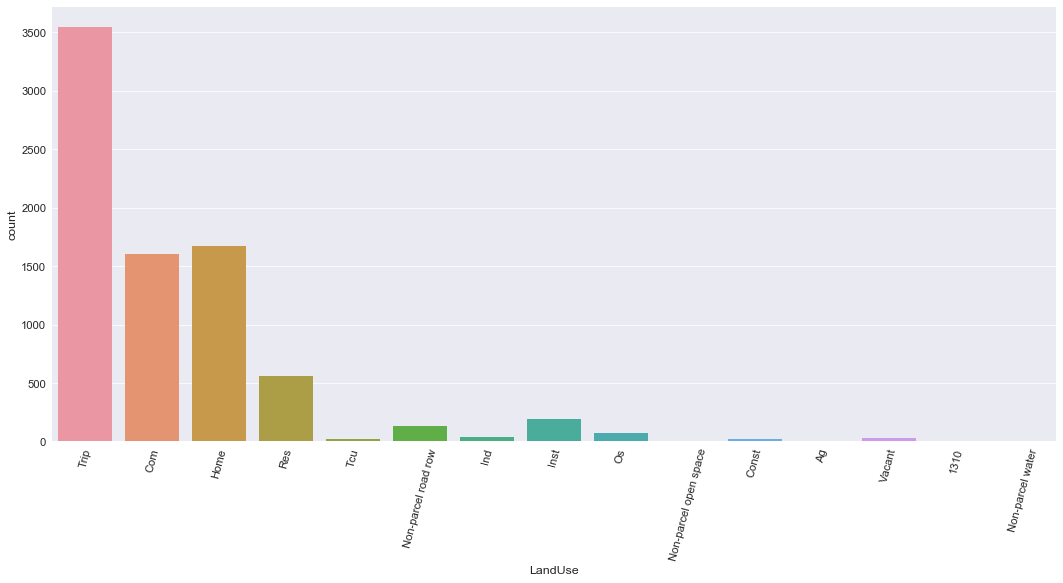

In [77]:
sns.set_context('paper',font_scale=1.4)
plt.figure(figsize=(18,8))
ax = sns.countplot(Data.LandUse)
ax = plt.xticks(rotation=75)

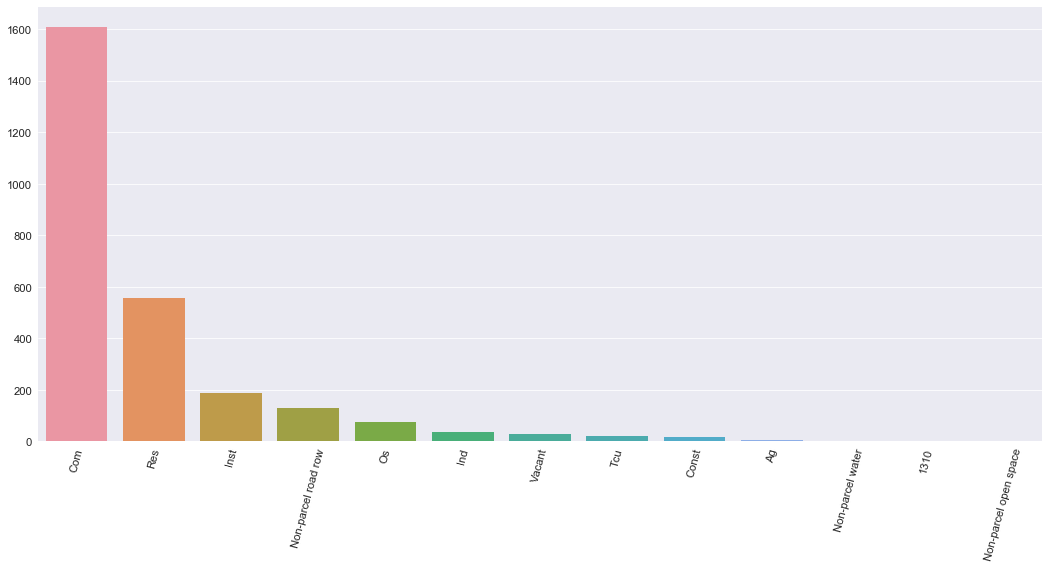

In [78]:
c = Data.LandUse.value_counts(normalize=False)
sns.set_context('paper',font_scale=1.4)
plt.figure(figsize=(18,8))
sns.barplot(x=c[2:].index,y=c[2:].values)
ax = plt.xticks(rotation=75)

In [50]:
len(LocData)

1608

array([<matplotlib.axes._subplots.AxesSubplot object at 0x121d25da0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x121ea15c0>], dtype=object)

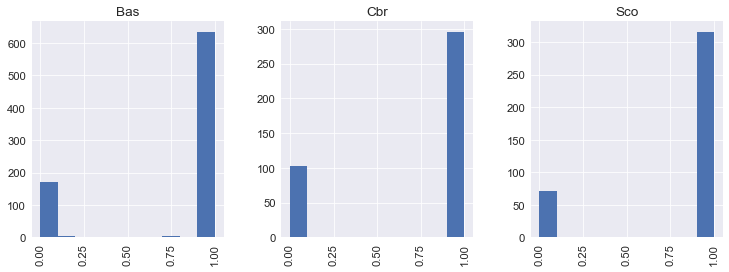

In [52]:
LocData = Data[(Data['LandUse']=='Com')]
LocData.hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x121ab7ef0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1217fca20>], dtype=object)

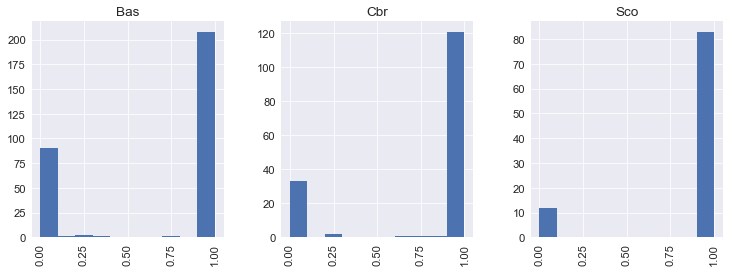

In [54]:
Data[(Data['LandUse']=='Res')].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1214d4b38>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1224387b8>], dtype=object)

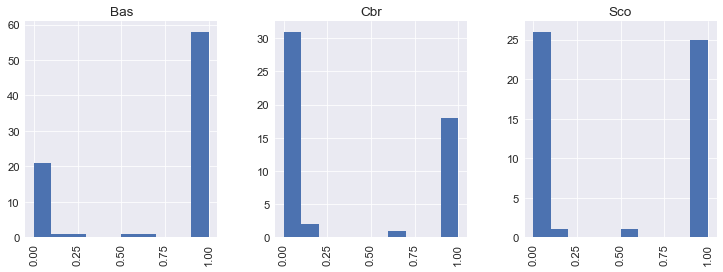

In [55]:
Data[(Data['LandUse']=='Inst')].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x122548c50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x12271cef0>], dtype=object)

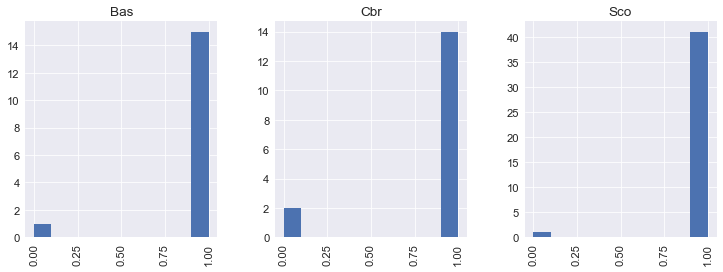

In [56]:
Data[(Data['LandUse']=='Os')].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))

In [ ]:
Data['MeanSpeed'] = [float(x) for x in Data['MeanSpeed']] # convert MeanSpeed to float

In [91]:
Data['Duration'] = Data['EndTime']  - Data['BeginTime']

TypeError: unsupported operand type(s) for -: 'str' and 'str'

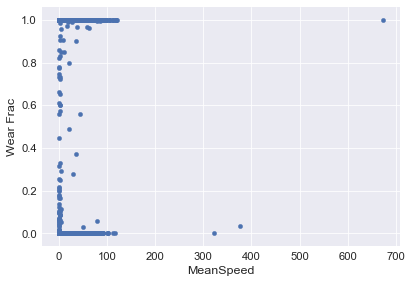

In [92]:
BraceData = Data[(~(Data['LandUse']=='Home')|(Data['LandUse']=='Trip')&(Data['Brace']=='Cbr'))]
ax = BraceData.plot(x='MeanSpeed',y='Wear Frac',kind='scatter')
# ax.set_xlim(-.1,10)

In [79]:
Data['MeanSpeed'] = [float(x) for x in Data['MeanSpeed']]

## Time spent at home

In [15]:
Data['Brace'].unique()

array(['Cbr', 'Sco', 'Bas'], dtype=object)

In [21]:
durCbr = Data[(Data['LandUse']=='Home')&(Data['Brace']=='Cbr')]['Duration']
durCbr = durCbr.values.astype(float)
durCbr=durCbr[~np.isnan(durCbr)]
durSCO = Data[(Data['LandUse']=='Home')&(Data['Brace']=='Sco')]['Duration']
durSCO = durSCO.values.astype(float)
durSCO=durSCO[~np.isnan(durSCO)]
durBase = Data[(Data['LandUse']=='Home')&(Data['Brace']=='Bas')]['Duration']
durBase = np.asarray([float(x) for x in durBase.values if type(x) is float])
durBase=durBase[~np.isnan(durBase)]

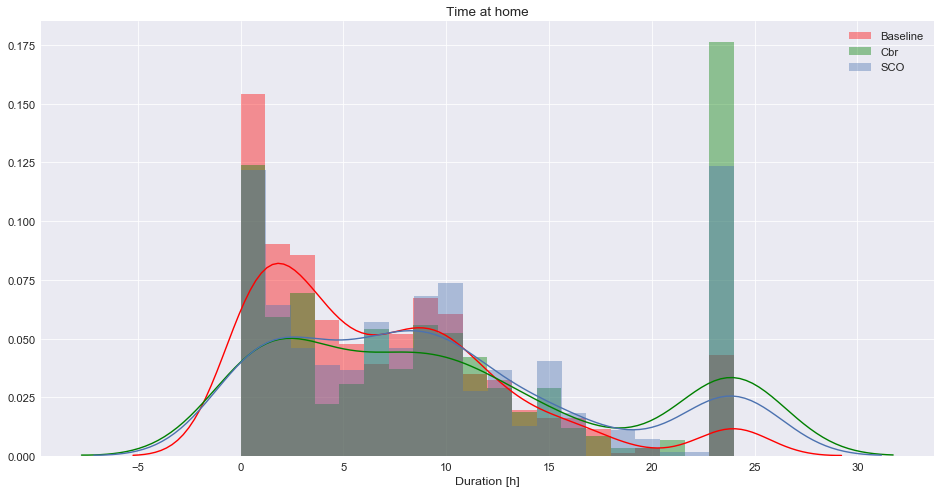

In [22]:
nb = 20
sns.set_context(font_scale=3)
plt.figure(figsize=(16,8))
sns.distplot(durBase/60,color='r',bins=nb)
sns.distplot(durCbr/60,color='g',bins=nb)
sns.distplot(durSCO/60,bins=nb)
plt.xlabel('Duration [h]')
plt.legend(['Baseline','Cbr','SCO'])
plt.title('Time at home')

## Time spent in trips

In [23]:
durCbr = Data[(Data['LandUse']=='Trip')&(Data['Brace']=='Cbr')]['Duration']
durCbr = durCbr.values.astype(float)
durSCO = Data[(Data['LandUse']=='Trip')&(Data['Brace']=='Sco')]['Duration']
durSCO = durSCO.values.astype(float)
durBase = Data[(Data['LandUse']=='Trip')&(Data['Brace']=='Bas')]['Duration']
durBase = durBase.values.astype(float)

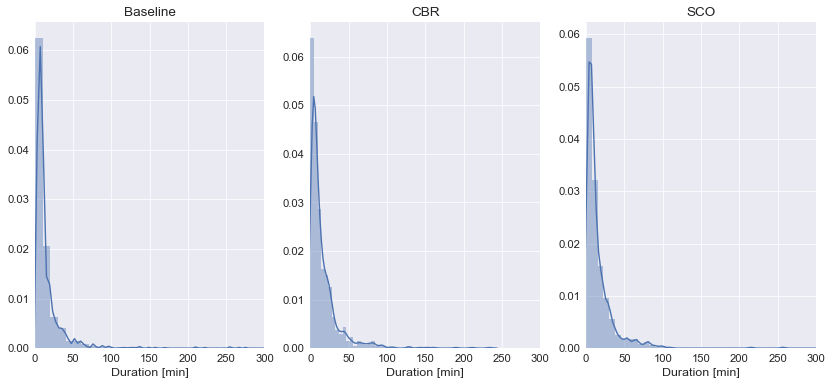

In [24]:
fig = plt.figure(figsize=(14,6))
fig.add_subplot(131)
ax = sns.distplot(durBase)
plt.xlim([0,300])
plt.title('Baseline')
plt.xlabel('Duration [min]')
fig.add_subplot(132)
ax = sns.distplot(durCbr)
plt.xlim([0,300])
plt.title('CBR')
plt.xlabel('Duration [min]')
fig.add_subplot(133)
ax = sns.distplot(durSCO)
plt.xlim([0,300])
plt.title('SCO')
plt.xlabel('Duration [min]')

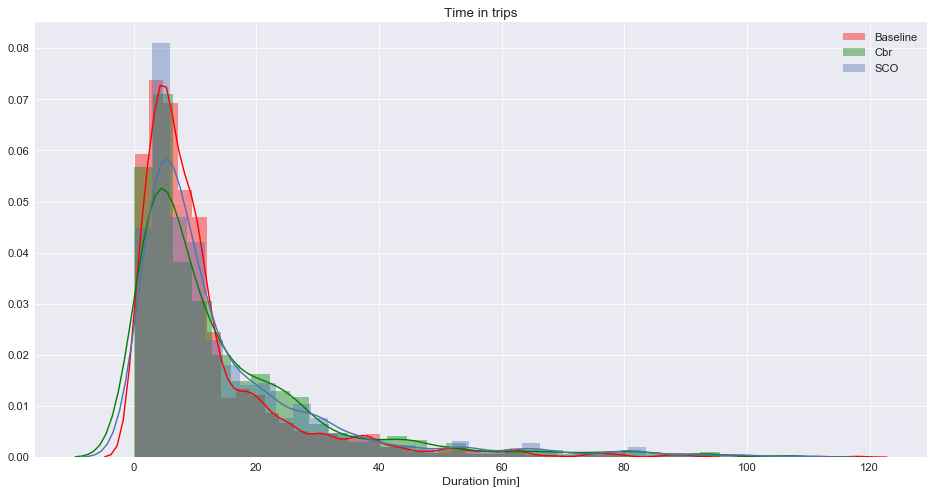

In [25]:
sns.set_context(font_scale=3)
plt.figure(figsize=(16,8))
sns.distplot(durBase[durBase<120],color='r')
sns.distplot(durCbr[durCbr<120],color='g')
sns.distplot(durSCO[durSCO<120])
plt.legend(['Baseline','Cbr','SCO'])
plt.xlabel('Duration [min]')
plt.title('Time in trips')

## Time spent at locations other than home and trip

In [26]:
durCbr = Data[~((Data['LandUse']=='Trip')|(Data['LandUse']=='Home'))&(Data['Brace']=='Cbr')]['Duration']
durCbr = durCbr.values.astype(float)
durSCO = Data[~((Data['LandUse']=='Trip')|(Data['LandUse']=='Home'))&(Data['Brace']=='Sco')]['Duration']
durSCO = durSCO.values.astype(float)
durBase = Data[~((Data['LandUse']=='Trip')|(Data['LandUse']=='Home'))&(Data['Brace']=='Bas')]['Duration']
durBase = durBase.values.astype(float)

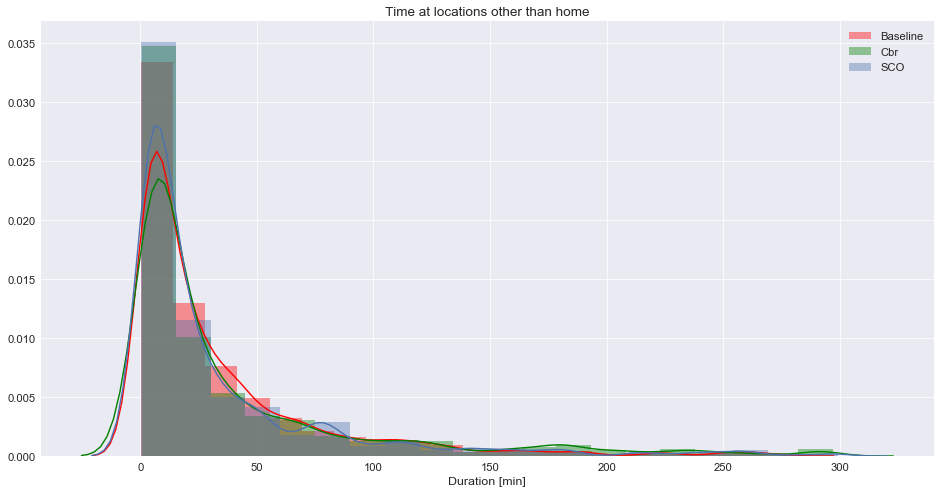

In [27]:
nb = 20
sns.set_context(font_scale=3)
plt.figure(figsize=(16,8))
sns.distplot(durBase[durBase<300],color='r',bins=nb)
sns.distplot(durCbr[durCbr<300],color='g',bins=nb)
sns.distplot(durSCO[durSCO<300],bins=nb)
plt.xlabel('Duration [min]')
plt.legend(['Baseline','Cbr','SCO'])
plt.title('Time at locations other than home')

## Wear Fractions for each brace
* Proportion of trips w/wo brace
* Correlation of wearfrac and Trip duration

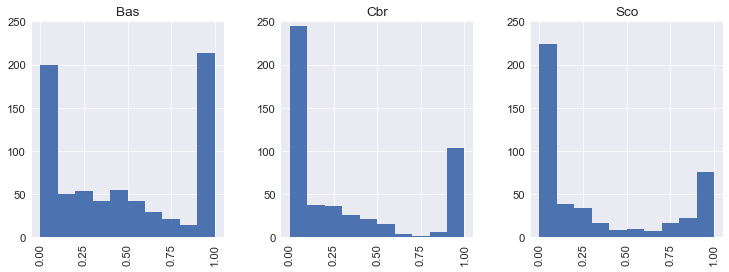

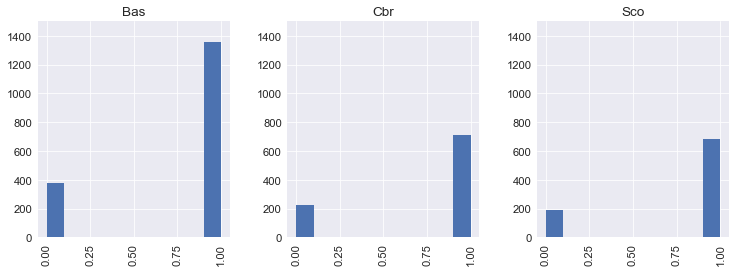

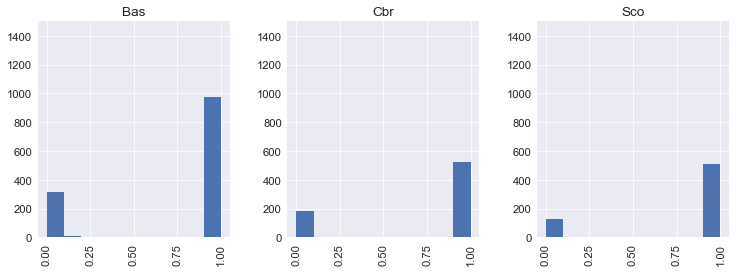

In [126]:
#wearfrac during trips,home and other use
ax = Data[(Data['LandUse']=='Home')].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))
for a in ax:
    a.set_ylim([0,250])
ax = Data[(Data['LandUse']=='Trip')].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))
for a in ax:
    a.set_ylim([0,1500])
ax = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))].hist(column='Wear Frac',by='Brace',figsize=(12,4),layout=(1,3))
for a in ax:
    a.set_ylim([0,1500])

* Break the information for locations visited (neither home nor trip) by subject

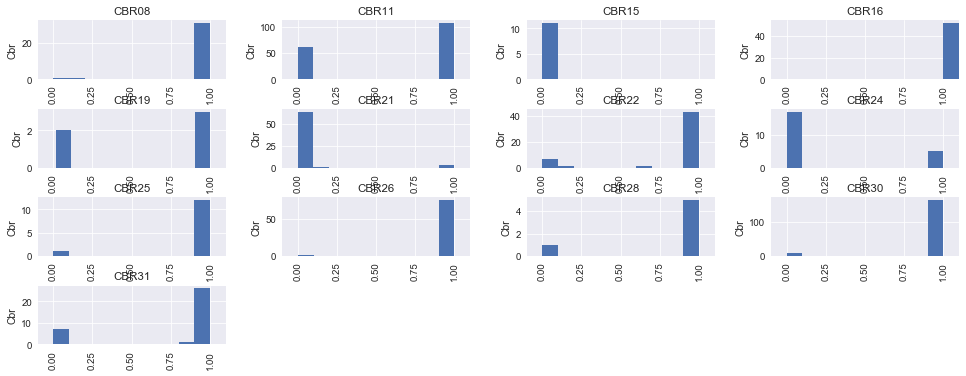

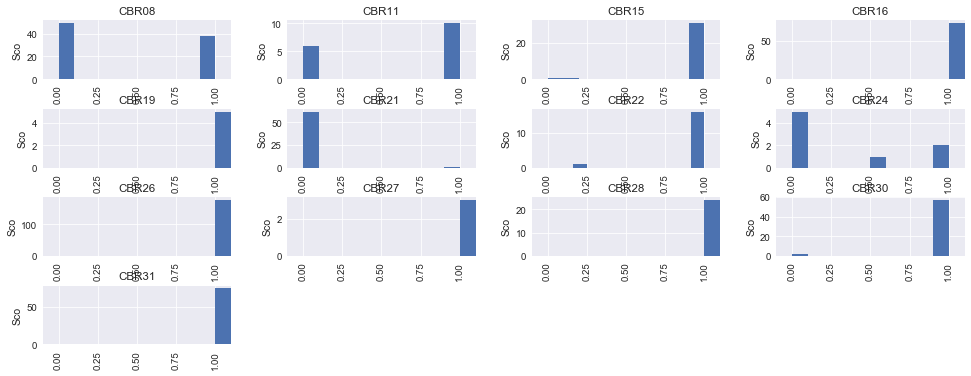

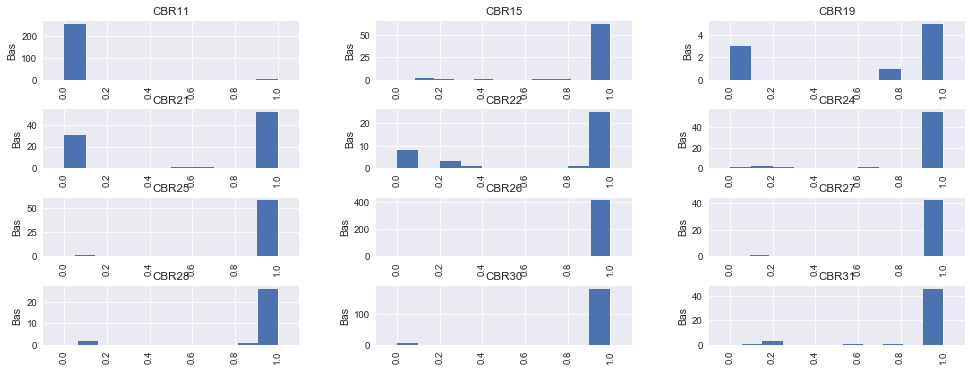

In [194]:
sns.set_context('paper',font_scale=1.2)
for brace in Data['Brace'].unique():
    ax = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Brace']==brace)].hist(column='Wear Frac',by='SubjID',figsize=(16,6))
    for a in ax.reshape(-1):
        a.set_xlim([-0.1,1.1])
        a.set_ylabel(str(brace))

Half subjects were consistent at wearing each brace across all trials. 

# Do people travel further from home with the cbrace?
* Median distance from home with each brace

In [208]:
#plot test datapoint
import gmplot
gmap = gmplot.GoogleMapPlotter(41.75554804, -87.91244198, 16)
gmap.scatter([home[0],home[0]],[home[1],home[1]],'#3B0B39', size=100,marker=False)
gmap.draw("mymap.html")

In [541]:
??gmplot.GoogleMapPlotter

In [ ]:
#store distance of each location visited from home
distall = pd.Series()
for s in Data.SubjID.unique():
    
    #mean lat,lon home for subj
    homelat = Data[(Data['SubjID']==s)&(Data['LandUse']=='Home')]['Mean Lat'].mean()
    homelon = Data[(Data['SubjID']==s)&(Data['LandUse']=='Home')]['Mean Lon'].mean()
    Datai = Data.loc[Data['SubjID']==s]            
    print(s)
    #distance of all locations from home
    d = []
    for k in range(len(Datai)):
        lat = Datai.iloc[k]['Mean Lat']
        lon = Datai.iloc[k]['Mean Lon']
        try:
            d.append(vincenty((homelat,homelon),(lat,lon)).meters/1000)
        except(UnboundLocalError): #nan lat,lon
            print('found nan lat/lon')
            d.append(np.nan)
     
    print(len(d))
    
    #aggregate distances for all subjects
    distall = distall.append(pd.Series(data=d,index=Data.loc[Data['SubjID']==s]['SubjID']))

In [90]:
#assigning new index to df Data to match with Series
Data.index = distall.index
Data['DistanceHome'] = distall

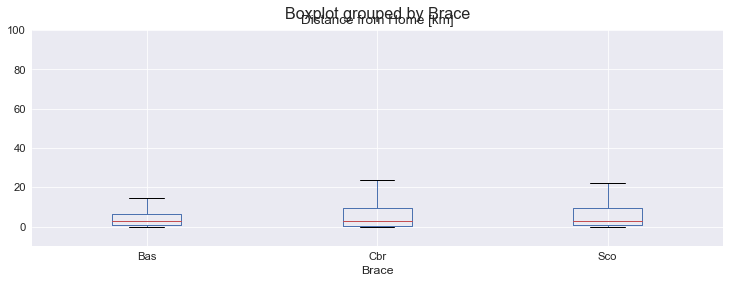

In [103]:
#plot distance from home for locations based on brace
ax2 = Data[~((Data['LandUse']=='Home')&(Data['LandUse']=='Trip'))].boxplot(column='DistanceHome',by='Brace',figsize=(12,4))
ax2.set_ylim([-10,100])
ax2.set_title('Distance from Home [km]')

## Distance traveled from home with each brace

In [ ]:
ax2 = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Brace']=='Cbr')&(Data['Wear Frac']>0.75)].boxplot(column='DistanceHome',by=['SubjID'],figsize=(12,4))
ax2.set_ylim([-10,100])
ax2 = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Brace']=='Cbr')&(Data['Wear Frac']<0.5)].boxplot(column='DistanceHome',by=['SubjID'],figsize=(12,4))
ax2.set_ylim([-10,100])

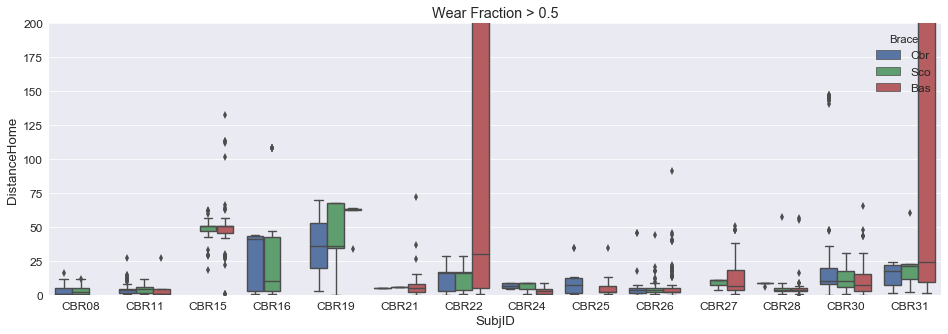

In [203]:
Datalocs = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Wear Frac']>0.5)]
fig = plt.figure(figsize=(16,5))
# fig.add_subplot(211)
ax = sns.boxplot(x='SubjID',y='DistanceHome',hue='Brace',data=Datalocs)
ax.set_ylim([0,200])
plt.title('Wear Fraction > 0.5')
sns.set_context('paper',font_scale=1.5)

# Datalocs = Data[~((Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Wear Frac']<0.5)]
# fig.add_subplot(212)
# ax = sns.boxplot(x='SubjID',y='DistanceHome',hue='Brace',data=Datalocs)
# ax.set_ylim([0,200])
# plt.title('Wear Fraction < 0.5')
# sns.set_context('paper',font_scale=1.5)

In [289]:
#plot locations visited by CBR22 and 31
s = 'CBR22'
d = Data.loc[(Data['SubjID']==s)]#&(~(Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))]
homelat = d[d['LandUse']=='Home']['Mean Lat'].mean()
homelon = d[d['LandUse']=='Home']['Mean Lon'].mean()
gmap = gmplot.GoogleMapPlotter(homelat, homelon, 16)

In [290]:
d = Data.loc[(Data['SubjID']==s)&(~(Data['LandUse']=='Home')|(Data['LandUse']=='Trip'))&(Data['Brace']=='Cbr')]
for l in range(len(d)):
    lat = d.iloc[l]['Mean Lat']
    lon = d.iloc[l]['Mean Lon']
    ll = np.array([lat,lon])
    gmap.scatter([ll[0],ll[0]],[ll[1],ll[1]],'#3B0B39', size=200,marker=False)

gmap.draw("mymap.html")

# distinct locations visited per brace